# Image Classifier with non-image features

Attempting to add the demographic information (age, sex, as well as image type) to a CNN model in order to improve the accuracy

In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

sns.set(style='white')

Using TensorFlow backend.


Loading the training CSV, which contains the paths, the labels, and the features (age, sex, type of image)

In [8]:
USER = 'Gabi'

if USER == 'Gabi':
    PATH = '/Volumes/GBackup/Data/CheXpertDataset'
elif USER == 'Alex':
    PATH = 'C:/blah'
elif USER == 'Vita':
    PATH = "/Users/My_Drive/Desktop/amliNet/Data"
else:
    PATH = input('What is the path for where you have stored the CheXpert dataset file?')
    
df = pd.read_csv(PATH + '/train.csv')
print(df.shape)
df.head()


(223414, 19)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


## Preprocessing

Edit the urls so keras can find the images, replace unknowns with 'no' and maybes with 'yes', and remove trivial outliers (unknown sex and age of 0 - four images)

In [9]:
def edit_urls(url):
    pieces = url.split('/')
    newurl = ''
  
      #removing the previous path 'CheXpert-v1.0-small' and including the PATH
    for i, piece in enumerate(pieces):
        if i > 0:
            newurl+= '/' + piece
        elif i == 0:
            newurl += PATH

    return newurl

df['Path'] = df['Path'].apply(edit_urls)
outcomes = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']
df[outcomes] = df[outcomes].fillna(0)
df[outcomes] = df[outcomes].replace(-1,1)
df = df[df['Age'] > 1]
df = df[(df['Sex'] == 'Male') | (df['Sex'] == 'Female')]

print(df.shape)
df.head()

(223410, 19)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,87,Frontal,AP,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Female,83,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Creation

I want to see if ditching the 'flow from directory' drastically decreases the speed of the model... because it seems like it would be so much easier if we didn't have to use that, and it would be a lot more pliable. (for this test, using just the lateral images as a smaller starting set)

In [12]:
laterals = df[df['Frontal/Lateral'] == 'Lateral']
laterals.shape

(32387, 19)

Doing a test-train split here so that each model is trained on the same dataset. I also added 'Age' and 'Sex' along with path to the features section (renamed to train_feats from train_images, since it also includes that info) - basically, it looks like the original dataframe except it's been shuffled and split into a testing (80%) and validation (20%) set.

In [17]:
from sklearn.model_selection import train_test_split

train_feats, val_feats, train_labels, val_labels = train_test_split(
    laterals[ ['Path', 'Age', 'Sex'] ], laterals[outcomes], test_size=0.2, random_state=42)

print(image_train.shape)
print(label_train.shape)

(25909, 3)
(25909, 14)


In [19]:
train_df = pd.concat([train_feats, train_labels], axis=1)
val_df = pd.concat([val_feats, val_labels], axis=1)

val_df.head()

,Path,Age,Sex,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
48168,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,53,Male,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40103,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,29,Female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11036,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,54,Male,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91561,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,65,Male,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
54714,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,37,Male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model 1: Simple model using flow from directory

First, make the image generators. This code takes a hot minute to run and load all the images or whatever it does in the background.

In [20]:
from keras.preprocessing.image import ImageDataGenerator

#scale the color information to 0 to 1 instead of 0 to 255
datagen = ImageDataGenerator(rescale=1./255)

#For the classifier to work, for some reason it has to be in string format 
val_df['No Finding str'] = val_df['No Finding'].apply(str)
train_df['No Finding str'] = train_df['No Finding'].apply(str)

train_generator = datagen.flow_from_dataframe(
    train_df, 
    directory=None, 
    x_col='Path', 
    y_col='No Finding str', 
    target_size=(256, 256), 
    color_mode='grayscale', 
    classes=None, 
    class_mode='binary', 
    batch_size=32, ##
    shuffle=True, 
    seed=None, 
    subset=None, 
    drop_duplicates=True
)

val_generator = datagen.flow_from_dataframe(
    val_df, 
    directory=None, 
    x_col='Path', 
    y_col='No Finding str', 
    target_size=(256, 256), 
    color_mode='grayscale', 
    classes=None, 
    class_mode='binary', #later figure out classifier 
    batch_size=32, ##
    shuffle=True, 
    seed=None, 
    subset=None, 
    drop_duplicates=True
)

Found 25909 validated image filenames belonging to 2 classes.
Found 6478 validated image filenames belonging to 2 classes.


Using the simple model from Vita (without the first conv2d 64 layer to try to save on time)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(256,256,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.train.AdamOptimizer(),
    metrics=['accuracy']
)

In [25]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=30,
        epochs=5,
        validation_data=val_generator,
        validation_steps=15
)

Epoch 1/5
30/30 [==============================] - 64s 2s/step - loss: 18.5937 - acc: 0.6917 - val_loss: 5.4779 - val_acc: 0.8188
Epoch 2/5
30/30 [==============================] - 54s 2s/step - loss: 1.6503 - acc: 0.7594 - val_loss: 0.6881 - val_acc: 0.7042
Epoch 3/5
30/30 [==============================] - 62s 2s/step - loss: 0.4941 - acc: 0.7906 - val_loss: 0.4386 - val_acc: 0.8188
Epoch 4/5
30/30 [==============================] - 51s 2s/step - loss: 0.4082 - acc: 0.8250 - val_loss: 0.4661 - val_acc: 0.7917
Epoch 5/5
30/30 [==============================] - 51s 2s/step - loss: 0.4449 - acc: 0.8313 - val_loss: 0.4328 - val_acc: 0.8292


Start time: 2:59pm  ....
End time: 3:03pm .... 
Total time: 4 minutes


Benefits:
* easy to fit into keras
* probably faster (but by how much?)
* no preprocessing needed


Negatives:
* Not sure if it's possible to add non-image features
* hard to know what's happening (were the images scaled? turned to grayscale? i think yes, no, but i'm not sure)

The total accuracy on this simple model was 83%

### Model 2: Simple model using cv2

In [31]:
#to install cv2
#!pip install opencv-python

In [61]:
from PIL import ImageOps, Image
import numpy as np
import cv2 as cv

def add_padding(df_row):
    '''
    Downloads the image, then adds padding that contains the age + sex of the patient,
    then compresses into the ideal size. 
    '''
    age = df_row['Age']
    sex = df_row['Sex']
    path = df_row['Path']
    
    SIZE = 256
    padding = (2,2,2,2)

    #open with cv2
    frame = cv.imread(path)
    
    #convert to PIL image type and add the padding
    im = Image.fromarray(frame)

    scaled_age = int(255 * age / 100)
    age_color = (scaled_age, scaled_age, scaled_age, 1)
    sex_color = (255,255,255,1) if sex == 'Female' else (0,0,0,1)

    #adding the sex on the outside and the age on the inside
    im = ImageOps.expand(im, padding, age_color)
    im = ImageOps.expand(im, padding, sex_color)

    #resize to 256 by 256, as the model expects
    im = im.resize((SIZE,SIZE), Image.ANTIALIAS)

    #turn black and white - these are bone images, probably don't need color. (It actually crashes without this...)
    #could also probably edit the contrast in this function later if wanted.
    im = ImageOps.grayscale(im)

    #return it to an arraytype
    newframe = np.asarray(im)

    #scale it from [0,255] to [0,1]
    newframe = newframe / 255

    return newframe

Male 39


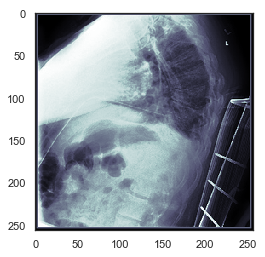

Female 31


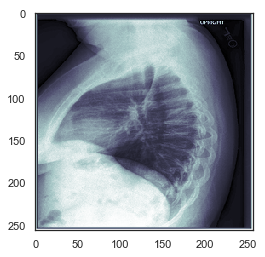

Male 29


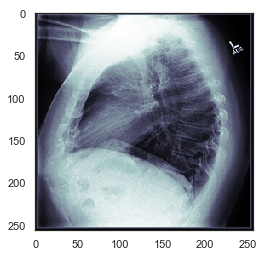

Male 19


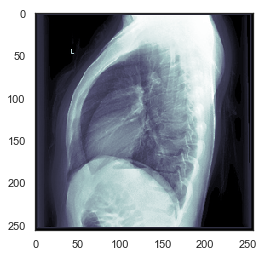

Male 37


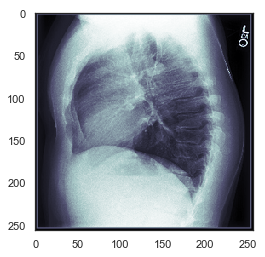

Male 50


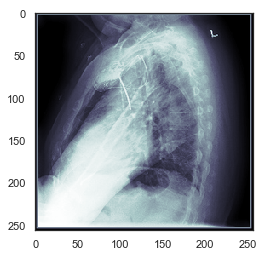

In [62]:
#test a couple images
for i in range(6):
    tester = train_df.iloc[i]
    age = tester['Age']
    sex = tester['Sex']
    path = tester['Path']
    print(sex, age)
    newframe = add_padding(tester)

    xray = Image.fromarray(newframe)
    plt.imshow(xray, cmap='bone')
    plt.show()

Now use this method to add images to the model. (The model architecture is exactly the same as above)

In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(256,256,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.train.AdamOptimizer(),
    metrics=['accuracy']
)

In [73]:
import time

start = time.time()
print(start)

#doing the testing set first because it should be smaller
testing_data = val_df.apply(add_padding, axis=1)
end = time.time()
print('Done with testing set. It took:', (end-start), 'seconds to run')

start2 = time.time()
training_data = train_df.apply(add_padding, axis=1)
end = time.time()
print('Done with training set. It took an additional:', (end-start2), 'seconds to run')

print('Total time elapsed:', (end-start))

1563220165.502163
Done with testing set. It took: 223.45303797721863 seconds to run
Done with training set. It took an additional: 959.0446240901947 seconds to run
Total time elapsed: 1182.5067691802979


In case that output goes away, it took FOREVER. exact time:
* testing set (6500ish images): 223 seconds (4-ish minutes)
* training set (25000ish images): 959 seconds (16-ish minutes)
total time: 1200ish seconds (20 minutes)


(at least it scales linearly)
(my computer is very warm now)


but maybe this is okay if a more complicated model is going to take a day to run anyways (this only has to happen once, then the images are passed to the model as an array)

ugh okay this didn't work - it smushed them all together? the thing below can't use them...

In [ ]:
training_list = np.array(training_data.to_list())
print(training_list)

In [83]:
model.fit(
    x=training_data.to_numpy(),
    y=train_df['No Finding'], 
    batch_size=32, #mimicking the data generation
    epochs=5, #same as above 
    #validation_split=0.0, 
    #validation_data = val_data, 
    steps_per_epoch=30, #same as above
    #validation_steps=15, #same as above 
    #validation_freq=1
)

ValueError: Error when checking input: expected conv2d_3_input to have 4 dimensions, but got array with shape (25909, 1)